In [1]:
# Jupyter options
%load_ext autoreload
%autoreload
%config IPCompleter.greedy=True

# Some basic imports to use
import tensorflow_datasets as tfds
import tensorflow.compat.v2 as tf
import numpy as np
import random
from tensorflow import keras
import matplotlib.pyplot as plt

# Just set some seeds so we are consistent across runs
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

# tfds works in both Eager and Graph modes
# just really make sure we are in the correct tensorflow mode
tf.compat.v1.enable_eager_execution()

tf.compat.v1.random.set_random_seed(random_seed) # just so it is forward compatible

# Data loading
We are going to use the [Dogs vs Cats Dataset from Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765), and use the [Tensorflow catalog to load them](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs)

In [2]:
# train is the only split that exists
# label 1 is dog, 0 is cat

train = tfds.load("cats_vs_dogs", split='train[:10]')
val = tfds.load("cats_vs_dogs", split='train[80%:]')

#train, val = tf.split(dataset, num_or_size_splits=2)
#print(train.shape)
#print(val.shape)

# Data Analysis

Label: dog tensor: (100, 100, 3)
Label: dog tensor: (377, 500, 3)


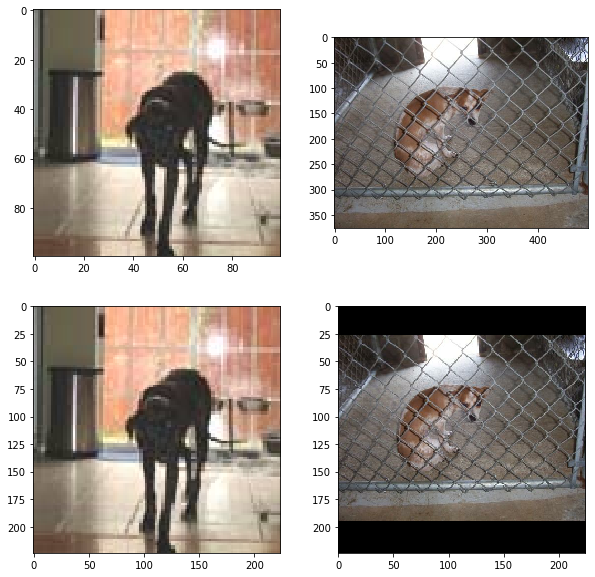

In [3]:
%matplotlib inline
# we shuffle the data here without seed so it changes everytime you run
fig = plt.figure(figsize=(10, 10))

img_size = 224
for i, sample in enumerate(train.shuffle(128).take(2)):
    image, label = sample["image"], sample["label"]
    print("Label: {} tensor: {}".format("dog" if label == 1 else "cat", image.shape))
    fig.add_subplot(2, 2, i+1)
    plt.imshow(image)

    image = tf.image.resize_with_pad(
        image,
        img_size,
        img_size,
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
        #antialias=True
    )  
    image = tf.cast(image, dtype=tf.uint8)
    
    fig.add_subplot(2, 2, i+3)
    plt.imshow(image)
    
    # We also need to check the shape of the tensor
    

plt.show()

In [4]:
# Resize all the images so they are the same

def resize_apply(ds):
    image, label = ds["image"], ds["label"]
    image = tf.image.resize_with_pad(
        image,
        img_size,
        img_size,
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
        #antialias=True
    )  
    return tf.cast(image, dtype=tf.uint8), label#tf.cast(label, dtype=tf.float32)



# Create Model

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

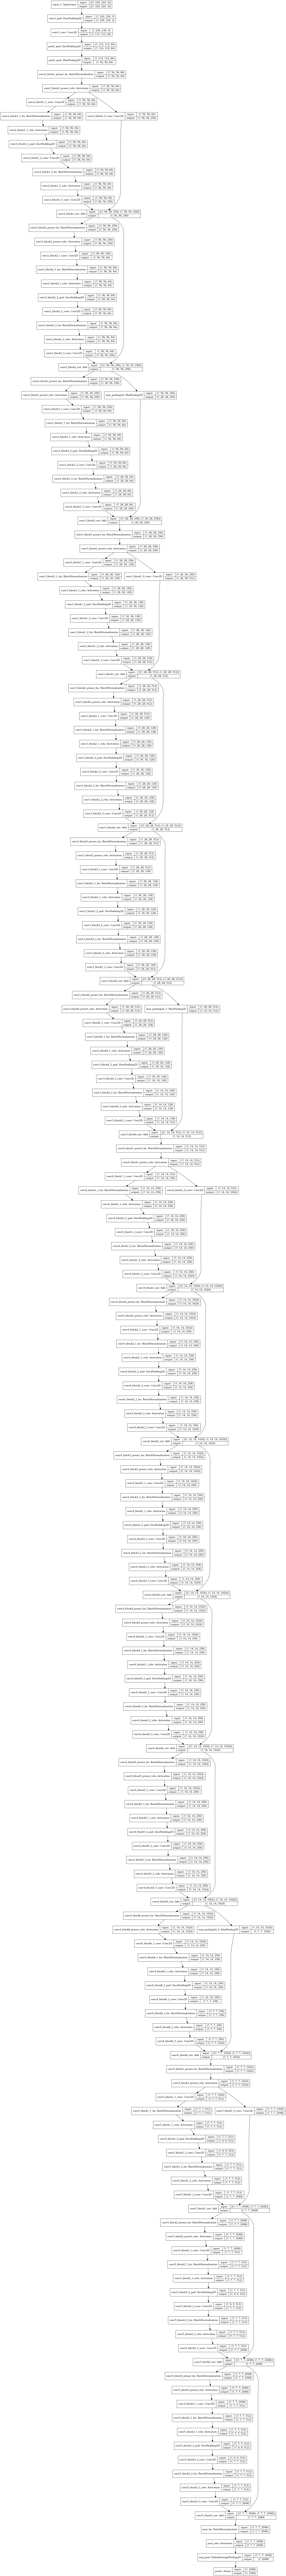

In [5]:
# Let's actually create a model now
'''
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
'''

from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions, ResNet50V2

model = ResNet50V2()

print(model.summary())
# The question/None marks are because the model doesn't know how many samples we are going to pass into it
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

# Model Run

In [23]:
X = train.map(resize_apply).shuffle(10000).batch(64)
pred = model.predict(X, use_multiprocessing=True)
decode_predictions(pred, top=2)

[[('n07613480', 'trifle', 1.0),
  ('n02089973', 'English_foxhound', 7.631507e-27)],
 [('n07613480', 'trifle', 1.0),
  ('n02089973', 'English_foxhound', 1.5046904e-10)],
 [('n02356798', 'fox_squirrel', 0.9994351),
  ('n04254777', 'sock', 0.000559066)],
 [('n02089973', 'English_foxhound', 1.0),
  ('n07613480', 'trifle', 1.2965483e-28)],
 [('n07613480', 'trifle', 1.0),
  ('n02089973', 'English_foxhound', 2.9185045e-08)],
 [('n07613480', 'trifle', 1.0),
  ('n02089973', 'English_foxhound', 1.3322029e-09)],
 [('n07613480', 'trifle', 1.0),
  ('n02089973', 'English_foxhound', 1.739812e-20)],
 [('n07613480', 'trifle', 1.0), ('n02356798', 'fox_squirrel', 1.9706201e-38)],
 [('n02089973', 'English_foxhound', 0.9977564),
  ('n07613480', 'trifle', 0.0022435659)],
 [('n07613480', 'trifle', 1.0),
  ('n02089973', 'English_foxhound', 5.305789e-11)]]

# Model Performance

In [7]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

NameError: name 'history' is not defined

# Model Analysis